## **Descripción**
Una empresa de retail está replanteando la estrategia con la que le presta dinero a sus clientes para que realicen sus compras. **En este momento están buscando distinguir entre los diferentes tipos de clientes** para poder ajustar los servicios que se les ofrece a cada uno de ellos.

## **Requerimientos**
Se pide buscar una herramienta que permita **diferenciar entre tipos de clientes** con el fin de entregarles productos/servicios financieros ajustados a sus necesidades.

## **Detalle Recursos**
Se dispondrá de la base de datos clientes_retail.csv, la cual contiene información correspondiente a la emisión de los estados financieros de sus clientes durante un año. Cabe mencionar, que un cliente que tenga un monto en mora por 3 meses o más, será considerado como un deudor moroso (No así los casos en 2 o 1 mes de atraso).

Base de datos consta de 35,799,227 registros y 19 columnas:

* ID_CLIENTE: Identificación única del cliente.
* TIPO_PRODUCTO: Tipo de producto financiero del cliente, este puede ser:
* C = Pago en cuotas (2 o más).
* R = Pago Revolving (0 o más cuotas).
* FECHA_EMISION: Fecha en que se emite el Estado de Cuenta (EECC) y por tanto determina la fecha en que el cliente debe pagar sus obligaciones.
* MORA_1: Monto en mora por 1 mes.
* MORA_2: Monto en mora por 2 meses.
* MORA_3: Monto en mora por 3 meses.
* MORA_4: Monto en mora por 4 meses.
* SALDO_FAVOR: Saldo a favor del cliente al momento de emitir EECC.
* SALDO_PENDIENTE: Saldo de la facturación anterior.
* PAGOS: Suma de pagos dentro del mes (antes de la facturación).
* CARGO: Suma de cargos correspondientes al mes de facturación.
* TOTAL_MES: Monto total del mes.
* INTERESES: Intereses a pagar.
* MINIMO: Pago mínimo.
* MONTO_ATRASADO: Monto atrasado.
* MONTO_CANCELAR: Monto total a cancelar.

## **Preprocesamiento de los datos**
Debido a que el dataset consta de un csv con más de 30 millones de observaciones, es que se opta por preprocesar la información con técnicas de Big Data, más en concreto mediante Spark que permite la manipulacion de grandes volúmenes de información

Se comienza por instalar la libería pyspark que permitirá trabajar con un gran volumen de datos

In [ ]:
!pip install pyspark 

Luego se importan las liberías necesarias para el trabajo del CSV

In [ ]:
# Librerías para manejo y exploración de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Librerías para el trabajo con pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT

In [ ]:
#Inicialización de trabajo con spark
spark = SparkSession\
        .builder\
        .appName('proyecto')\
        .enableHiveSupport()\
        .getOrCreate()
spark


plt.style.use('seaborn-whitegrid')

* Se ocupa drive para poder conectar con los datos a procesar y asi tener una mayor reproducción a todo tipo de usuario en este notebook
* **En caso de trabajar con este notebook en otro conexto, es necesario modificar los path de carga**

Luego se realiza un pre-visualización de datos en bruto

In [ ]:
df= spark\
.read\
.option("delimiter", ";")\
.csv(path, header=True)

In [ ]:
df.show(2, vertical = True )

-RECORD 0------------------------------
 ID_CLIENTE      | AXB0781000001001AAa 
 TIPO_PRODUCTO   | R                   
 FECHA_EMISION   | 1/14/2016           
 MORA_1          | NA                  
 MORA_2          | NA                  
 MORA_3          | NA                  
 MORA_4          | NA                  
 SALDO_FAVOR     |           0         
 SALDO_PENDIENTE |   3249616,5         
 PAGOS           |     -684000,0       
 CARGO           |    1779654,6        
 TOTAL_MES       |   4397190,3         
 INTERESES       |  57688              
 MINIMO          |   777482            
 MONTO_ATRASADO  |        0            
 MONTO_CANCELAR  |   777482            
 VENCPROX_1      |   504171            
 VENCPROX_2      |   504171            
 FEC_APER        | 19891201            
-RECORD 1------------------------------
 ID_CLIENTE      | AXB0781000001001AAa 
 TIPO_PRODUCTO   | R                   
 FECHA_EMISION   | 2/14/2016           
 MORA_1          |   777482            


In [ ]:
df.printSchema()

root
 |-- ID_CLIENTE: string (nullable = true)
 |-- TIPO_PRODUCTO: string (nullable = true)
 |-- FECHA_EMISION: string (nullable = true)
 |-- MORA_1: string (nullable = true)
 |-- MORA_2: string (nullable = true)
 |-- MORA_3: string (nullable = true)
 |-- MORA_4: string (nullable = true)
 |-- SALDO_FAVOR: string (nullable = true)
 |-- SALDO_PENDIENTE: string (nullable = true)
 |-- PAGOS: string (nullable = true)
 |-- CARGO: string (nullable = true)
 |-- TOTAL_MES: string (nullable = true)
 |-- INTERESES: string (nullable = true)
 |-- MINIMO: string (nullable = true)
 |-- MONTO_ATRASADO: string (nullable = true)
 |-- MONTO_CANCELAR: string (nullable = true)
 |-- VENCPROX_1: string (nullable = true)
 |-- VENCPROX_2: string (nullable = true)
 |-- FEC_APER: string (nullable = true)



Comentarios:
* Se observa que los datos corresponden al historial de los distintos clientes a lo largo de los meses del año 2016.
* Debido a la cantidad de datos se decidio trabajar con el promedio y la desviación estandar de cada cliente agrupado por el total de observaciones que aparece según su ID, sin contabilizar las fechas. 
* Como el objetivo es clasificar los clientes en base a su comportamiento, se opta por trabajar con los promedios de las variables MORA_1, MORA_2, MORA_3 Y MORA_4 para cada uno de los usuario
* Para el resto de las variables se define trabajar con el promedio y la desviación estadar
* Para mantener una noción de la temporalidad o la cantidad de meses de historia con la que cuenta el cliente, se eliminará la columna fecha y se reemplazará por una columna que indique la cantidad de meses involucrados en la obtención de los promedios y desviación estandar 
* Las medidads anteriores tiene por obejtivo reducir a una única observación a cada cliente y de esta forma aplicar modelos de clusterización
* Otro punto a consierar es que todas las variables son reconocidas como string, por lo que es necesaria transformarlas a float o int según corresponda

En base a lo definido anteriormente, a continuación, se preprocesa el dataset

In [ ]:
df= spark.sparkContext.textFile(path)

In [ ]:
#borramos la primera fila 
df_columns = df.first()
df_prueba = df.filter(lambda x: x != df_columns)
df_prueba.take(1)

['AXB0781000001001AAa;R;1/14/2016;NA;NA;NA;NA;          0;  3249616,5;    -684000,0;   1779654,6;  4397190,3; 57688;  777482;       0;  777482;  504171;  504171;19891201']

In [ ]:
#convierte el tipo de  las variables y cambia los NA a 0
df_procesado = df_prueba\
                .map(lambda x : x.split(";"))\
                .map(lambda x : (str(x[0]),str(x[1]),float(x[3].replace("NA","0")),float(x[4].replace("NA","0")),float(x[5].replace("NA","0")),float(x[6].replace("NA","0")), float(x[7]), float(x[8].replace(' ', '').replace(",",".")),float(x[9].replace("  ", "").replace(",",".")),float(x[10].replace("  ", "").replace(",",".")),float(x[11].replace(" ", "").replace(",",".")),float(x[12].replace(" ", "").replace(",",".")),float(x[13].replace(" ", "").replace(",",".")),float(x[13].replace(" ", "").replace(",",".")),float(x[14].replace(" ", "").replace(",","."))))

In [ ]:
df_procesado.take(1)

[('AXB0781000001001AAa',
  'R',
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3249616.5,
  -684000.0,
  1779654.6,
  4397190.3,
  57688.0,
  777482.0,
  777482.0,
  0.0)]

In [ ]:
#Agregamos columnas 
df_2 = spark.createDataFrame(df_procesado,["ID_CLIENTE","TIPO_PRODUCTO","MORA_1","MORA_2","MORA_3","MORA_4","SALDO_FAVOR","SALDO_PENDIENTE","PAGOS","CARGO","TOTAL_MES","INTERESES","MINIMO","MONTO_ATRASADO","MONTO_CANCELAR"])

Guardamos el csv con los cambios realizados 

In [ ]:
df_2.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('clientes_retail_final.csv')

In [ ]:
df_csv = spark.read.option("delimiter",',').option( "header" , True ).option("inferSchema" , True).csv("/content/clientes_retail_final.csv/clientes_retail_final.csv")

In [ ]:
df_csv.printSchema()

root
 |-- ID_CLIENTE: string (nullable = true)
 |-- TIPO_PRODUCTO: string (nullable = true)
 |-- MORA_1: double (nullable = true)
 |-- MORA_2: double (nullable = true)
 |-- MORA_3: double (nullable = true)
 |-- MORA_4: double (nullable = true)
 |-- SALDO_FAVOR: double (nullable = true)
 |-- SALDO_PENDIENTE: double (nullable = true)
 |-- PAGOS: double (nullable = true)
 |-- CARGO: double (nullable = true)
 |-- TOTAL_MES: double (nullable = true)
 |-- INTERESES: double (nullable = true)
 |-- MINIMO: double (nullable = true)
 |-- MONTO_ATRASADO: double (nullable = true)
 |-- MONTO_CANCELAR: double (nullable = true)



In [ ]:
df_csv_procesado = df_csv.select(df_csv.columns).groupBy("ID_CLIENTE","TIPO_PRODUCTO")\
                    .agg(f.avg("MORA_1").alias("AVG_MORA1"),
                         f.avg("MORA_2").alias("AVG_MORA2"),
                         f.avg("MORA_3").alias("AVG_MORA3"),
                         f.avg("MORA_4").alias("AVG_MORA4"),
                         f.avg("SALDO_FAVOR").alias("AVG_SALDO_FAVOR"),
                         f.stddev("SALDO_FAVOR").alias("STD_SALDO_FAVOR"),
                         f.avg("SALDO_PENDIENTE").alias("AVG_SALDO_PENDIENTE"),
                         f.stddev("SALDO_PENDIENTE").alias("STD_SALDO_PENDIENTE"),
                         f.avg("PAGOS").alias("AVG_PAGOS"),
                         f.stddev("PAGOS").alias("STD_PAGOS"),
                         f.avg("CARGO").alias("AVG_CARGO"),
                         f.stddev("CARGO").alias("STD_CARGO"),
                         f.avg("TOTAL_MES").alias("AVG_TOTAL_MES"),
                         f.stddev("TOTAL_MES").alias("STD_TOTAL_MES"),
                         f.avg("INTERESES").alias("AVG_INTERESES"),
                         f.stddev("INTERESES").alias("STD_INTERESES"),
                         f.avg("MINIMO").alias("AVG_MINIMO"),
                         f.stddev("MINIMO").alias("STD_MINIMO"),
                         f.avg("MONTO_ATRASADO").alias("AVG_MONTO_ATRASADO"),
                         f.stddev("MONTO_ATRASADO").alias("STD_MONTO_ATRASADO"),
                         f.avg("MONTO_CANCELAR").alias("AVG_MONTO_CANCELAR"),
                         f.stddev("MONTO_CANCELAR").alias("STD_MONTO_CANCELAR"),
                )

In [ ]:
df_csv_procesado.show(truncate = False)

+-------------------+-------------+------------------+---------+---------+---------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|ID_CLIENTE         |TIPO_PRODUCTO|AVG_MORA1         |AVG_MORA2|AVG_MORA3|AVG_MORA4|AVG_SALDO_FAVOR    |STD_SALDO_FAVOR   |AVG_SALDO_PENDIENTE|STD_SALDO_PENDIENTE|AVG_PAGOS         |STD_PAGOS         |AVG_CARGO         |STD_CARGO         |AVG_TOTAL_MES      |STD_TOTAL_MES     |AVG_TOTAL_MES     |STD_TOTAL_MES     |AVG_SALDO_PENDIENTE|STD_SALDO_PENDIENTE|AVG_MINIMO        |STD_MINIMO        |AVG_MONTO_ATRASADO|STD_MONTO_ATRASADO|AVG_MONTO_CANCELAR|STD_MONTO_CANCELAR|
+-------------------+-------------+------------------+----

In [ ]:
# Cantidad de veces que una persona a pagado 
df_csv_join = df_csv.select("ID_CLIENTE")\
              .groupBy("ID_CLIENTE")\
              .count()\
              .withColumnRenamed("count", "FRECUENCIA_PAGOS")\
              .withColumnRenamed("ID_CLIENTE","CLIENTES")

In [ ]:
# Join para obtener el dataframe pre-procesado final para su experimentación con ML
df_final = df_csv_join.join(df_csv_procesado, df_csv_join.CLIENTES == df_csv_procesado.ID_CLIENTE,"inner").drop("ID_CLIENTE")

In [ ]:
df_final.show(truncate = False)

+-------------------+----------------+-------------+------------------+------------------+------------------+---------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|CLIENTES           |FRECUENCIA_PAGOS|TIPO_PRODUCTO|AVG_MORA1         |AVG_MORA2         |AVG_MORA3         |AVG_MORA4|AVG_SALDO_FAVOR    |STD_SALDO_FAVOR   |AVG_SALDO_PENDIENTE|STD_SALDO_PENDIENTE|AVG_PAGOS          |STD_PAGOS         |AVG_CARGO         |STD_CARGO         |AVG_TOTAL_MES     |STD_TOTAL_MES     |AVG_INTERESES     |STD_INTERESES     |AVG_SALDO_PENDIENTE|STD_SALDO_PENDIENTE|AVG_MINIMO        |STD_MINIMO        |AVG_MONTO_ATRASADO|STD_MONTO_ATRASADO|AVG_MONTO_CANCELAR|STD_MONT

Guardamos el df pre-preprocesado en su versión final 

In [ ]:
df_final.coalesce(1).write.format('com.databricks.spark.csv').options(header='true').save('clientes_retail_2022_dsl.csv')

## **Comentarios:**
* Con el comando anterior se crear una carpeta con el nombre clientes_retail_2022.
* De esa carpeta se extrae el archivo CSV y es renonbrado "clientes_retail2022_dsl.csv

## **Analisis exploratio**

In [ ]:
# Carga de los datos pre-procesados
df_1 = pd.read_csv('/content/drive/MyDrive/proyecto_ds/clientes_retail_2022_dsl.csv')

In [ ]:
# Dado que las variables TOTAL_MES y MONTO_CANCELAR pueden ser calculadas como una combinación lineal de otras, 
# se opta por eliminarlas para evitar redundancia de información y que esta pueda afectar el modelo

df_1=df_1.drop(['STD_TOTAL_MES','AVG_TOTAL_MES','STD_MONTO_CANCELAR','AVG_MONTO_CANCELAR', "AVG_MINIMO", "STD_MINIMO"],axis=1)

In [ ]:
# Se explora la cantidad de observaciones obtenidas y la cantidad de atributos
print("Se tiene un total de {} registros".format(df_1.shape[0]))
print("Y un total de {} atributos". format (df_1.shape[1]))

Se tiene un total de 3464374 registros
Y un total de 19 atributos


In [ ]:
# Se explora la cantidad de datos nulos que tiene el dataset
df_1.isnull().sum()

CLIENTES                   0
FRECUENCIA_PAGOS           0
TIPO_PRODUCTO              0
AVG_MORA1                  0
AVG_MORA2                  0
AVG_MORA3                  0
AVG_MORA4                  0
AVG_SALDO_FAVOR            0
STD_SALDO_FAVOR        91160
AVG_SALDO_PENDIENTE        0
STD_SALDO_PENDIENTE    91160
AVG_PAGOS                  0
STD_PAGOS              91160
AVG_CARGO                  0
STD_CARGO              91160
AVG_INTERESES              0
STD_INTERESES          91160
AVG_MONTO_ATRASADO         0
STD_MONTO_ATRASADO     91160
dtype: int64

**Comentarios:**
* Se observa que las variables asocidadas a la desviación estandar contienen datos nulos. Esto tendría relazación en que algunos clientes tenian valor 0 para este atributo en el dataset original
* Debido a que la cantidad de observaciones con datos nulos es baja respecto a la totalidad (91.160 contra 3.464.374) se opta por eliminar dichar observaciones

In [ ]:
## Se eliminan NaN
df_1=df_1.dropna()

In [ ]:
#Se identifica el tipo de dato en cada atributo
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3373214 entries, 0 to 3464373
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   CLIENTES             object 
 1   FRECUENCIA_PAGOS     int64  
 2   TIPO_PRODUCTO        object 
 3   AVG_MORA1            float64
 4   AVG_MORA2            float64
 5   AVG_MORA3            float64
 6   AVG_MORA4            float64
 7   AVG_SALDO_FAVOR      float64
 8   STD_SALDO_FAVOR      float64
 9   AVG_SALDO_PENDIENTE  float64
 10  STD_SALDO_PENDIENTE  float64
 11  AVG_PAGOS            float64
 12  STD_PAGOS            float64
 13  AVG_CARGO            float64
 14  STD_CARGO            float64
 15  AVG_INTERESES        float64
 16  STD_INTERESES        float64
 17  AVG_MONTO_ATRASADO   float64
 18  STD_MONTO_ATRASADO   float64
dtypes: float64(16), int64(1), object(2)
memory usage: 514.7+ MB


**Comentarios:**
* Se observa que casi todas las variables son del tipo float, a excepción de CLIENTES Y TIPO PRODUCTO (OBJECT) y FRECUENCIA_PAGOS (Int)

In [ ]:
# Se carga un ejemplo de 5 observaciones para verificar que los datos fueron correctamente cargados
df_1.sample(5)

,CLIENTES,FRECUENCIA_PAGOS,TIPO_PRODUCTO,AVG_MORA1,AVG_MORA2,AVG_MORA3,AVG_MORA4,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO
1828118,AXB0981150110410ACz,12,R,0.0,0.0,0.0,0.0,-837687.416667,2.099250e+06,2865342.825,386953.633584,-3619261.500,1.786220e+06,3707796.975,1.776344e+06,0.000000,0.000000,469412.333333,285912.872646
504855,AXB0081144555557AEs,6,R,0.0,0.0,0.0,0.0,-102445.000000,9.146419e+04,-64309.500,80084.599975,-27891.000,6.035033e+04,27891.000,6.831872e+04,0.000000,0.000000,0.000000,0.000000
2652826,AXB0681007067867ABs,9,R,0.0,0.0,0.0,0.0,-3.666667,4.555217e+00,119184.200,326797.338867,-119172.100,3.268054e+05,125260.000,3.248453e+05,186.222222,440.861310,10245.222222,20095.377869
136108,AXB0381000091503ACw,12,R,0.0,0.0,0.0,0.0,-3.833333,3.242707e+00,46084.350,17795.461058,-46087.800,1.779612e+04,45356.775,1.814428e+04,0.833333,2.886751,22957.583333,15654.663328
596243,AXB0281200239351AFz,12,R,0.0,0.0,0.0,0.0,-32.083333,3.955539e+01,15499.500,6078.460982,-15528.375,6.079385e+03,14599.950,5.273375e+03,0.000000,0.000000,7406.666667,2360.732026


**Comentarios:**
* Se observa que los datos fueron correctamente cargados

In [ ]:
def color_df(val):
  '''
  Descripción: color_df tiene por objetivo mejorar la visual de una tabla resaltando en verde los colores mayor a 0 y en azul los valores menores a 0

  input: valores de la tabla

  output: tabla con colores

  ejemplo de aplicación:
  df.style.applymap(color_df)
  '''

  color='blue'if val <0 else 'green'
  return 'color: %s' % color

In [ ]:
# Se obtiene la estadistica descriptiba de las variables tipo int o float
df_1.describe().style.applymap(color_df)

,FRECUENCIA_PAGOS,AVG_MORA1,AVG_MORA2,AVG_MORA3,AVG_MORA4,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO
count,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000,3373214.000000
mean,10.946591,7800.650335,2917.588827,1568.604239,648.565328,-16000.806782,30300.794690,145839.877168,71693.690868,-105075.613003,80730.295291,110162.795402,66795.247911,1362.743204,865.945208,50354.448690,28427.372995
std,2.475276,28905.552797,16572.991324,11260.153795,5787.755865,353053.438346,1109498.907546,292928.865330,135603.908305,372336.969528,1005364.306398,375404.716521,1002409.349153,4652.003826,2285.240566,86492.904916,93438.215409
min,2.000000,0.000000,0.000000,0.000000,0.000000,-581686938.250000,0.000000,-36001362.300000,0.000000,-523689419.550000,0.000000,-1025626.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000,0.000000,0.000000,-3532.000000,0.000000,17353.725000,12340.400681,-120285.187500,12891.361204,15932.490341,9889.508436,0.000000,0.000000,7262.250000,4214.779752
50%,12.000000,0.000000,0.000000,0.000000,0.000000,-32.250000,18.666734,60274.537500,32962.017925,-47222.700000,34242.565118,50697.272727,26904.397652,2.000000,4.330127,25613.083333,11592.641181
75%,12.000000,4564.500000,0.000000,0.000000,0.000000,-0.833333,8645.412380,161974.903125,78666.208845,-14182.981071,81483.642822,126730.125000,64407.491444,506.750000,653.350207,59380.403409,25183.728957
max,12.000000,4077483.500000,2881507.500000,2970514.500000,1927896.250000,0.000000,2015021704.944831,25416945.300000,11587526.089364,443775.900000,1813797922.827632,523709410.650000,1813466551.150512,494024.250000,158222.028633,7558955.000000,7777424.137917


**Comentarios:**
* A primera vista se observa una gran dispersión en los datos, donde algunos atributos presentan un mínimo en 0 y un máximo con valores bajo -1e06 y sobre 1e06
* A continuación, se procede a analizar las distribuciones de los datos

### **Atributos tipo objetc y categoricas**

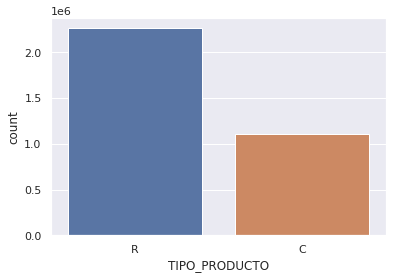

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="TIPO_PRODUCTO", data=df_1)

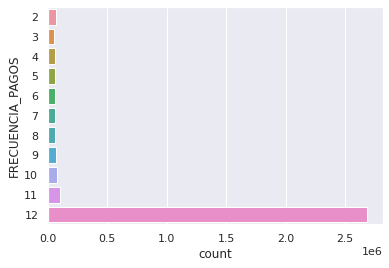

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="FRECUENCIA_PAGOS", data=df_1)

**Comentarios:**
* En ambas variables se observa un desbalance que podría afectar a la representatividad de los modelos que se trabajen en etapas posteriores
* Para FRECUENCIA_PAGOS se propone recodificar esta variable agrupando las frecuencias <=11 y de esta forma balancear este atributo

## **Atributos tipo int o float**

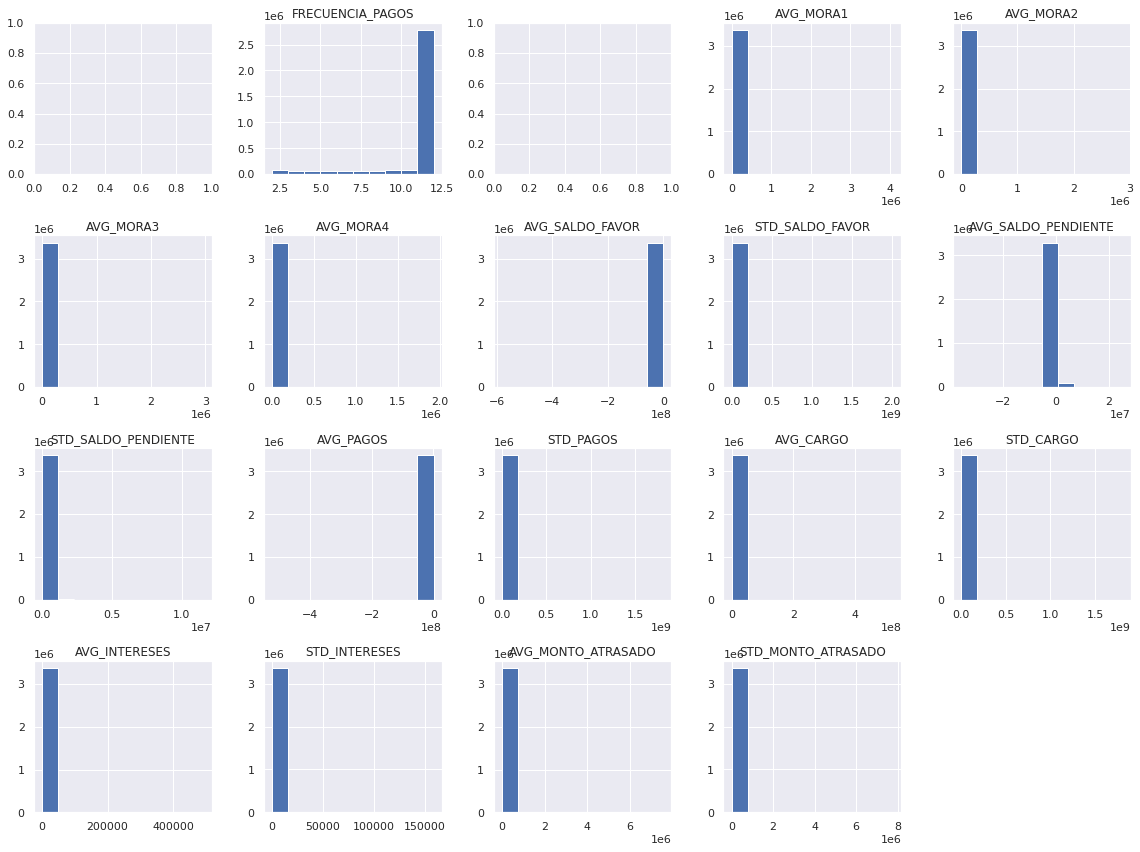

In [ ]:
plt.figure(figsize=(16,12))
rows = 4
cols = (df_1.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_1.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object' :
      serie.hist()
      plt.title(colnames)
        
plt.tight_layout()

## **Comentarios**:
* No se observa distribuciones claras en ningun atributo
* En general todos tiene su mayor cantidad de observaciones en torno a 0, con outlayers bajo -1e06 y sobre 1e06 que distorcionan su visivilidad y representatividad.
* Se procederá a aplicar un threshold inferior y superior de 1e05 para observar el comportamiento.

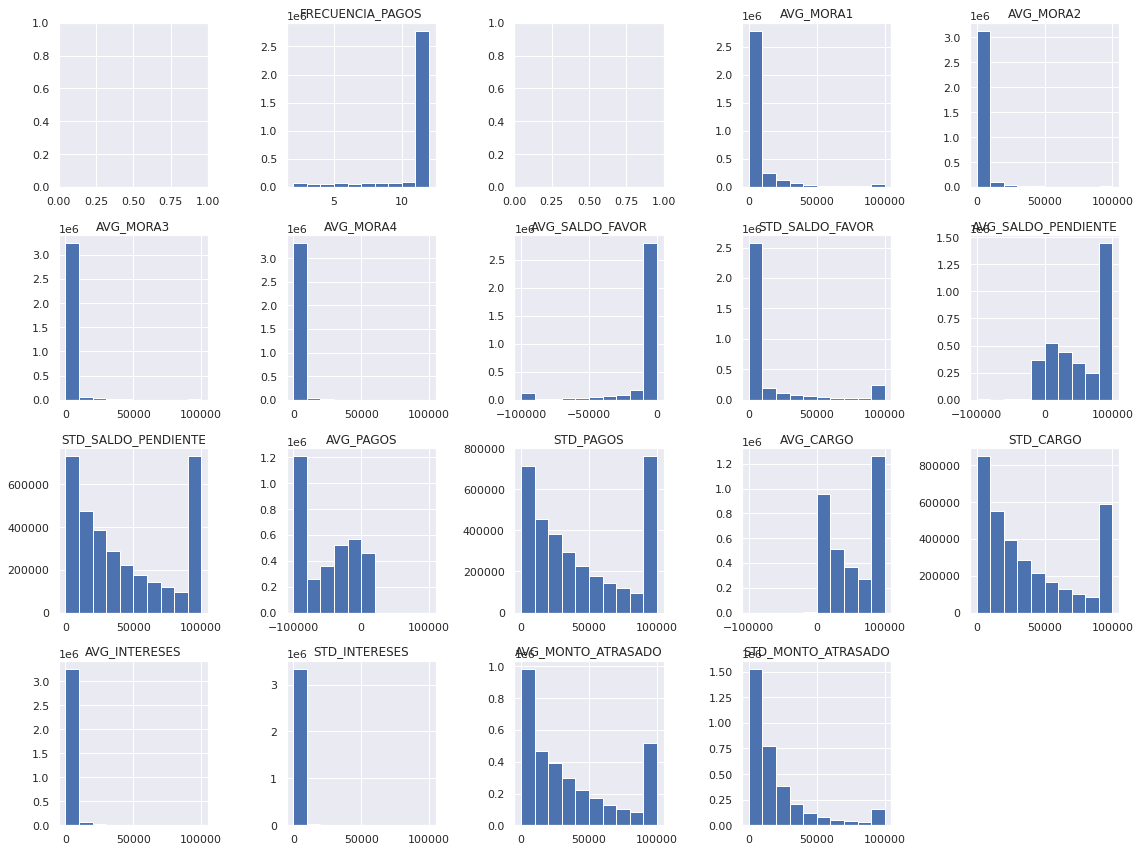

In [ ]:
plt.figure(figsize=(16,12))
rows = 4
cols = (df_1.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_1.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object' :
      serie.clip(upper=1e05, lower=-1e05).hist()
      plt.title(colnames)
        
plt.tight_layout()

## **Comentarios:**
* Se observa que al aplicar este límite inferior y superior, se pueden visualizar mejor las tendencias de las variables, las cuales en su mayoría estan concentradas en valores cercanos a 0, y luego la cantidad decrece.
* Para la variable FRECUENCIA_PAGO se observa que la mayoría de los clientes tienen una historia de 12 meses.
* Para algunas variables como STD_SALDO_PENDIENTE, STD_PAGOS, STD_CARGOS, AGV_MINIMO, STD_MINIMO, AGV_MONTO_ATRASADO se observan 2 máximos locales, uno cercano a 0 y el otro cercano al límite superior impuesto, lo que podría ser el indicio de 2 tipos de clientes.

## Recodificación de datos

1. Se elimina el atributo cliente, ya que no es necesario para el proceso de clusterización posterior

In [ ]:
df_pro=df_1.drop("CLIENTES", axis=1)

2. Recodificación de tipo de producto

In [ ]:
# Siguiendo las buenas prácticas se define como 1 a C y como 0 a R
df_pro["TIPO_PRODUCTO_RECO"]=np.where(df_pro["TIPO_PRODUCTO"]=="C",1,0)
df_pro=df_pro.drop("TIPO_PRODUCTO", axis=1)

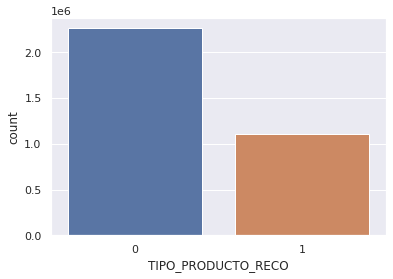

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="TIPO_PRODUCTO_RECO", data=df_pro)

3. Dato el análisis exploratorio es que en un principio se optará por filtrar el dataframe con entre -1e05 y 1e05 con tal limitar la cantidad de outliers

In [ ]:
df_pro=df_pro.clip(upper=1e05, lower=-1e05)

In [ ]:
print("Se tiene un total de {} registros".format(df_pro.shape[0]))
print("Y un total de {} atributos". format (df_pro.shape[1]))

Se tiene un total de 3373214 registros
Y un total de 18 atributos


4. Categorizar por deudor y no deudor: En base a lo sugerido para el problema, se recodifican las variables Mora_1, 2, 3 y 4, categorizando como deudor al usuario si es que presenta valores mayor a 0 en Mora 3 o Mora 4

In [ ]:
df_pro["Deudor"]=np.where(df_pro["AVG_MORA3"]!=0,1,0)

In [ ]:
df_pro=df_pro.drop(["AVG_MORA1", "AVG_MORA2", "AVG_MORA3", "AVG_MORA4"], axis=1)

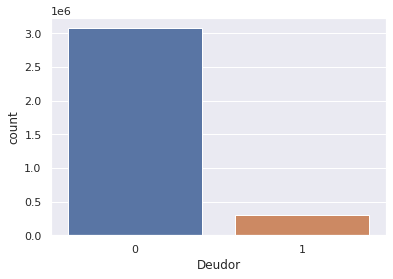

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Deudor", data=df_pro)

5. Una mirada final al dataset

In [ ]:
df_pro.head().style.applymap(color_df)

,FRECUENCIA_PAGOS,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO,TIPO_PRODUCTO_RECO,Deudor
0,12,0.000000,0.000000,1370.250000,89.204071,0.000000,0.000000,525.600000,1817.614117,26.500000,0.522233,883.166667,976.915818,0,0
1,12,-9.666667,33.486316,100000.000000,87060.169611,-58133.025000,53656.608730,50373.375000,42379.537103,0.000000,0.000000,55960.750000,47090.888017,1,1
2,12,0.000000,0.000000,978.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1087.000000,0.000000,0,0
3,3,0.000000,0.000000,23139.900000,24129.418995,-23139.900000,24129.418995,23139.900000,24129.418995,0.000000,0.000000,25711.000000,26810.465550,1,0
4,12,-146.333333,488.044397,100000.000000,100000.000000,-100000.000000,100000.000000,100000.000000,100000.000000,91.583333,202.004257,64805.666667,52002.446641,0,0


# **Modelo de Clusterización**

## **Comentario:**
* Para la clusterización se comenzará probando con el modelo kmeans, dada su simpleza de aplicación. 
* Para esto primero, se definirá el número de cluster óptimo utilizando la técnica del gráfico del codo, donde se escoge el número de cluster segun el punto de mayor disminución del valor de la inercia obtenido.
* También, para ratificar el valor obtenido se utiliza el gráfico de la silueta para comparar la cantidad óptima de cluster entre metodologías.
* Para un mejor desempeño del modelo se procede a normalizar los datos utilizando los mínimos y máximos de cada atributo.
* Otro parametro a considerar es el tiempo en que se demora en entrenar los modelos.


*Inercia: suma de las distancias al cuadrado de cada objeto del Cluster a su centroide*

In [ ]:
# Se procede a importar el modelo kmeans
from sklearn.cluster import KMeans

In [ ]:
# Se importa la librería time para la evaluación del tiempo en el entrenamiento de los modelos
import time

#### **Normalización de los datos**

In [ ]:
#Se eliminan las variables Binarias antes de normalizar los datos
df_2=df_pro.drop(["Deudor","TIPO_PRODUCTO_RECO"], axis=1)

In [ ]:
# Normalizar con mínimo y máximo
df_norm = (df_2-df_2.min())/(df_2.max()-df_2.min())

In [ ]:
# Se vuelven a agregar las variables del tipo binario las cuales no deben ser normalizadas
df_norm["Deudor"]=df_pro["Deudor"]
df_norm["TIPO_PRODUCTO_RECO"]=df_pro["TIPO_PRODUCTO_RECO"]

In [ ]:
# Se comprueba si el df contiene datos nulos por algun problema en la cantidad de observaciones
df_norm.isnull().sum()

FRECUENCIA_PAGOS       0
AVG_SALDO_FAVOR        0
STD_SALDO_FAVOR        0
AVG_SALDO_PENDIENTE    0
STD_SALDO_PENDIENTE    0
AVG_PAGOS              0
STD_PAGOS              0
AVG_CARGO              0
STD_CARGO              0
AVG_INTERESES          0
STD_INTERESES          0
AVG_MONTO_ATRASADO     0
STD_MONTO_ATRASADO     0
Deudor                 0
TIPO_PRODUCTO_RECO     0
dtype: int64

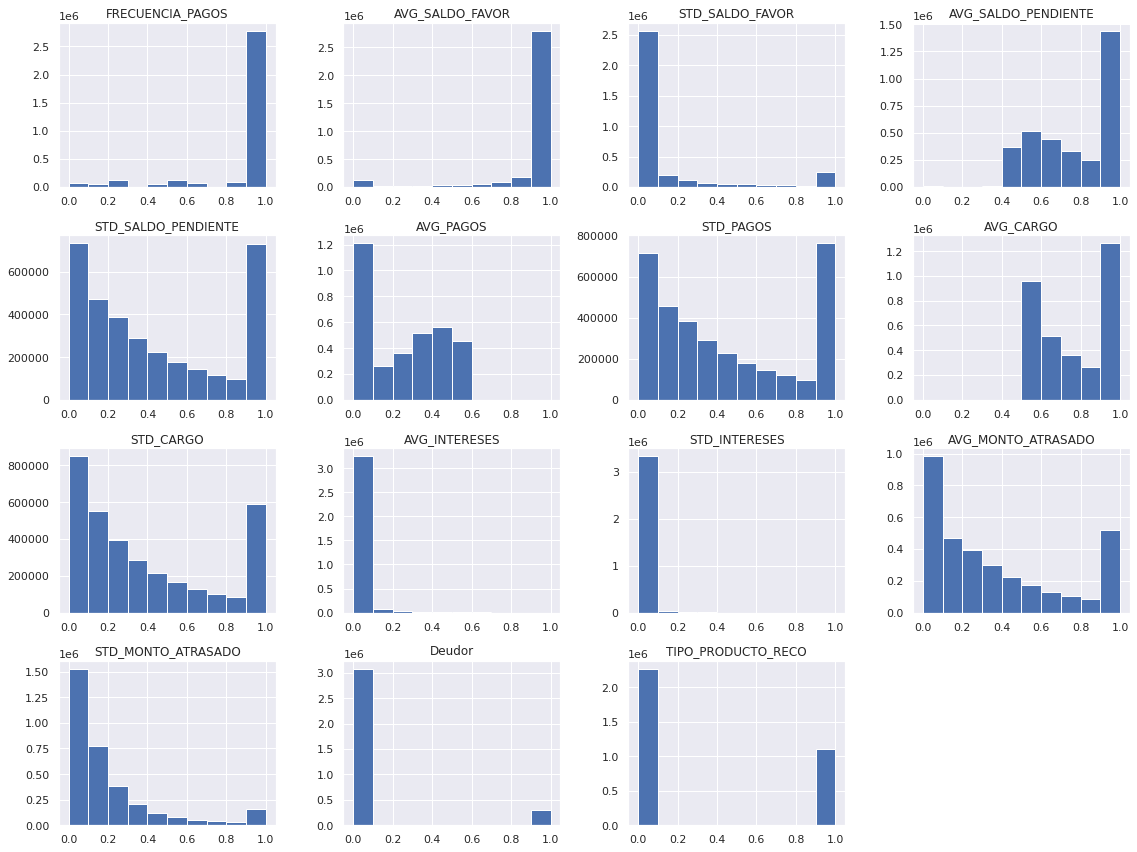

In [ ]:
# Se realiza una gráfica de los datos normalizados para comprobar que las distirbuciones se mantienen de la misma forma
# pero ahora con valores entre 0 y 1

plt.figure(figsize=(16,12))
rows = 4
cols = (df_norm.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_norm.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object' :
      serie.hist()
      plt.title(colnames)
        
plt.tight_layout()

* Se observa un la misma dispersión, pero entre valores de 0 a 1

In [ ]:
# Se procede a entrena el modelo con distintas cantidades de cluster y se guarda en una libería el valor obtenido de la incercia para luego graficar
w_na=[]
time_na=[]

start = time.time()
tiempo = 0

for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=1, max_iter=300).fit(df_norm)
  w_na.append(kmeans.inertia_)

  end = time.time()  
  tiempo = end - start - sum(time_na)
  time_na.append(tiempo)

  print('Entrenamiento {} finalizado, tiempo aproximado {} segundos'.format(i, round(tiempo,2)))

Entrenamiento 1 finalizado, tiempo aproximado 6.02 segundos
Entrenamiento 2 finalizado, tiempo aproximado 17.44 segundos
Entrenamiento 3 finalizado, tiempo aproximado 28.6 segundos
Entrenamiento 4 finalizado, tiempo aproximado 34.91 segundos
Entrenamiento 5 finalizado, tiempo aproximado 52.02 segundos
Entrenamiento 6 finalizado, tiempo aproximado 65.37 segundos
Entrenamiento 7 finalizado, tiempo aproximado 73.08 segundos
Entrenamiento 8 finalizado, tiempo aproximado 88.55 segundos
Entrenamiento 9 finalizado, tiempo aproximado 101.5 segundos
Entrenamiento 10 finalizado, tiempo aproximado 96.2 segundos


### Gráfico del codo

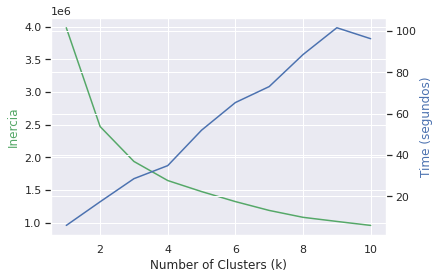

In [ ]:
# Se grafica el valor de la incercia obtenida para cada cantidad de cluster
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(1,11),w_na[:],'g-')
ax2.plot(range(1,11),time_na[:],'b-')
 
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inercia",color='g')
 
ax2.set_ylabel("Time (segundos)",color='b')
 
plt.show()


### Gráfica de la Silueta 

In [ ]:
df_norm.to_csv("Kmeans_retail.csv")

In [ ]:
df_spark = spark.read.csv('Kmeans_retail.csv', header = True, inferSchema = True)

In [ ]:
df_spark = df_spark.drop("_c0")

In [ ]:
df_spark.show(10,truncate = True)

+----------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+------------------+
|FRECUENCIA_PAGOS|   AVG_SALDO_FAVOR|     STD_SALDO_FAVOR|AVG_SALDO_PENDIENTE|STD_SALDO_PENDIENTE|          AVG_PAGOS|          STD_PAGOS|         AVG_CARGO|          STD_CARGO|       AVG_INTERESES|       STD_INTERESES|          AVG_MINIMO|          STD_MINIMO|  AVG_MONTO_ATRASADO|  STD_MONTO_ATRASADO|Deudor|TIPO_PRODUCTO_RECO|
+----------------+------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------+------------------+
|         

In [ ]:
to_dense_vector_udf = f.udf(lambda l: Vectors.dense(l), VectorUDT())
feats = df_spark.columns
df_spark_2 = df_spark.withColumn('features', f.array(*feats))\
            .withColumn("assembled_features", to_dense_vector_udf('features'))\
            .select("assembled_features")

In [ ]:
from pyspark.ml.clustering import KMeans as KMspark
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='assembled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMspark(featuresCol='assembled_features', k=i).setSeed(1)
    
    KMeans_fit=KMeans_algo.fit(df_spark_2)
    
    output=KMeans_fit.transform(df_spark_2)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)

Text(0, 0.5, 'cost')

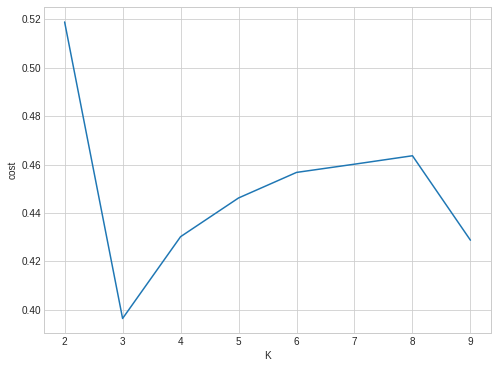

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("K")
ax.set_ylabel("cost")

## **Comentarios:**
* Para ambas metodologías se observa que la mayor tasa de cambio esta con k=2
* En el gráfico del codo se observan dos tasas de cambio a con k=3 y k=4.
* A continuación, se procederá a entrenar modelos con k=2, 3 y 4 y luego mediante gráficas de boxplot y analisis bivariado se definirá con cuantos cluster se observa una mejor segmentación de clientes.

## Entrenamiento con K=2

In [ ]:
%%time 
# Se entrena el modelo con k=2
kmeans_2 = KMeans(n_clusters=2, random_state=1, max_iter=300).fit(df_norm)

CPU times: user 22.2 s, sys: 1.84 s, total: 24 s
Wall time: 14.4 s


In [ ]:
# Se obtiene nuevo df
df_cluster_2=df_norm

In [ ]:
# Se añaden las asignaciones de cluster al nuevo df
df_cluster_2["Cluster"]=kmeans_2.labels_

In [ ]:
# Se realiza una exploración de la cantidad de asignaciones para cada cluster
df_cluster_2["Cluster"].value_counts('%')

0    0.585148
1    0.414852
Name: Cluster, dtype: float64

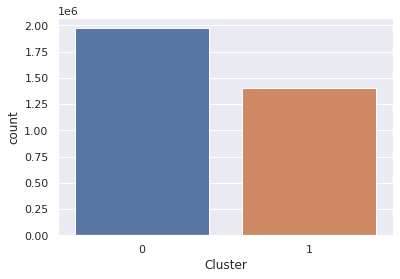

In [ ]:
# Se realiza una exploración gráfica de la distribución
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Cluster", data=df_cluster_2)

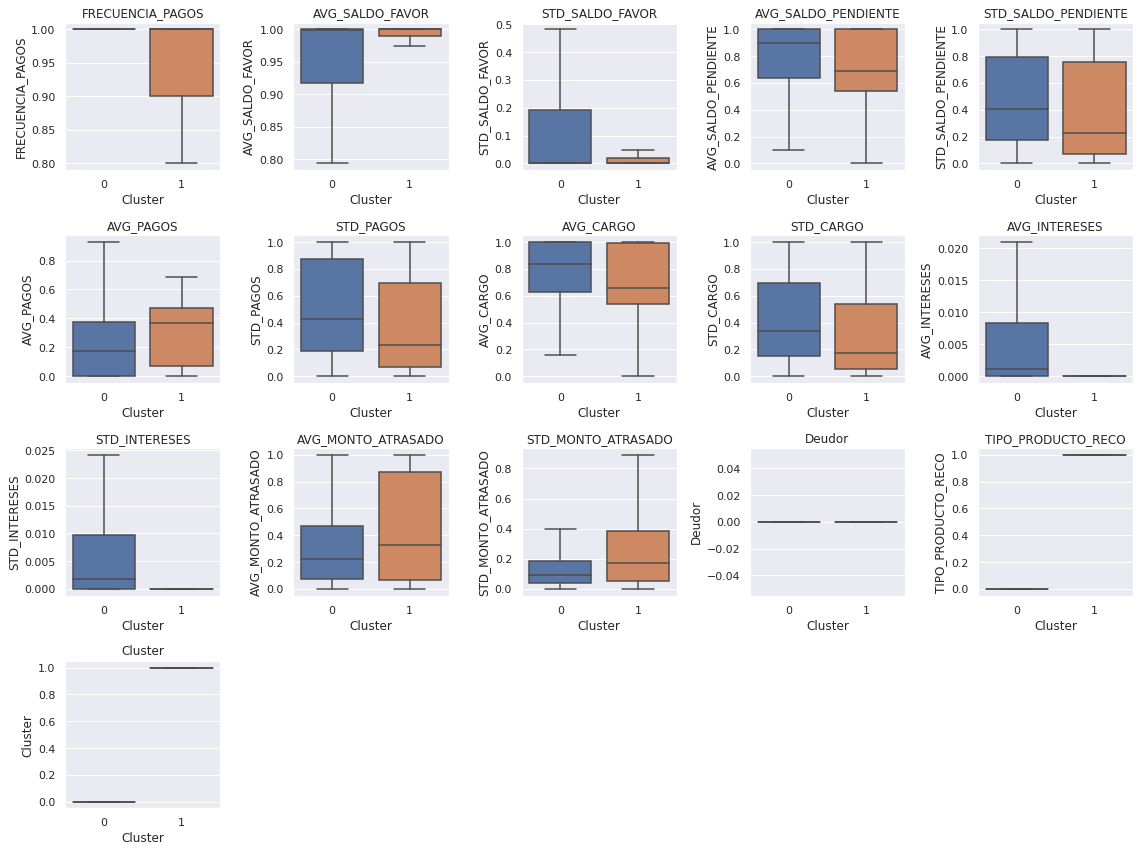

In [ ]:
# Se realizan los gráficos de boxplot para explorar si los cluster definidos presentan diferencias significativas en su distribución y si esto permite perfilar 2 tipos de clientes
plt.figure(figsize=(16,12))
rows = 4
cols = (df_cluster_2.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_cluster_2.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object':
      sns.boxplot(x=df_cluster_2['Cluster'],
                  y=serie,
                  showfliers=False)
      plt.title(colnames)
      
        
plt.tight_layout()

Text(0, 0.5, 'Promedio de montos atrasados')

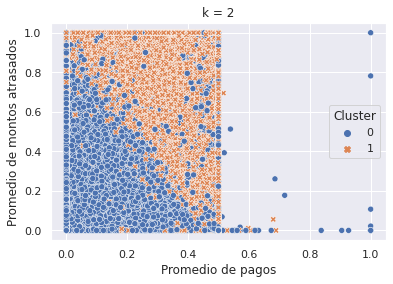

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de pagos
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_2,  
                x='AVG_PAGOS', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 2')

ax1.set_xlabel('Promedio de pagos')
ax1.set_ylabel('Promedio de montos atrasados')

Text(0, 0.5, 'Promedio de montos atrasados')

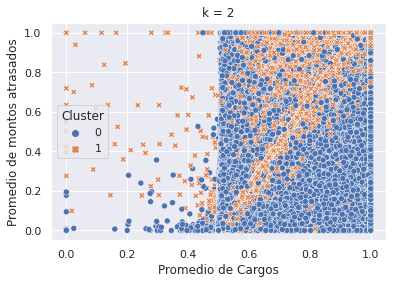

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de cargos mensuales
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_2,  
                x='AVG_CARGO', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 2')

ax1.set_xlabel('Promedio de Cargos')
ax1.set_ylabel('Promedio de montos atrasados')

## Entrenamiento con K=3

In [ ]:
%%time 
# Se entrena el modelo con k=3
kmeans_3 = KMeans(n_clusters=3, random_state=1, max_iter=300).fit(df_norm)

CPU times: user 47.3 s, sys: 3.38 s, total: 50.7 s
Wall time: 28.5 s


In [ ]:
# Se obtiene nuevo df
df_cluster_3=df_norm

In [ ]:
# Se añaden las asignaciones de cluster al nuevo df
df_cluster_3["Cluster"]=kmeans_3.labels_

In [ ]:
# Se realiza una exploración de la cantidad de asignaciones para cada cluster
df_cluster_3["Cluster"].value_counts('%')

1    0.376263
0    0.321634
2    0.302103
Name: Cluster, dtype: float64

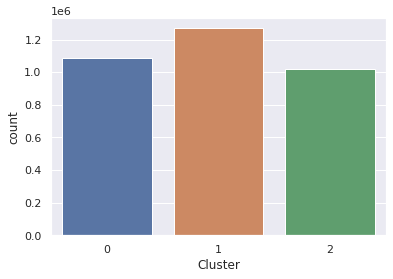

In [ ]:
# Se realiza una exploración gráfica de la distribución
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Cluster", data=df_cluster_3)

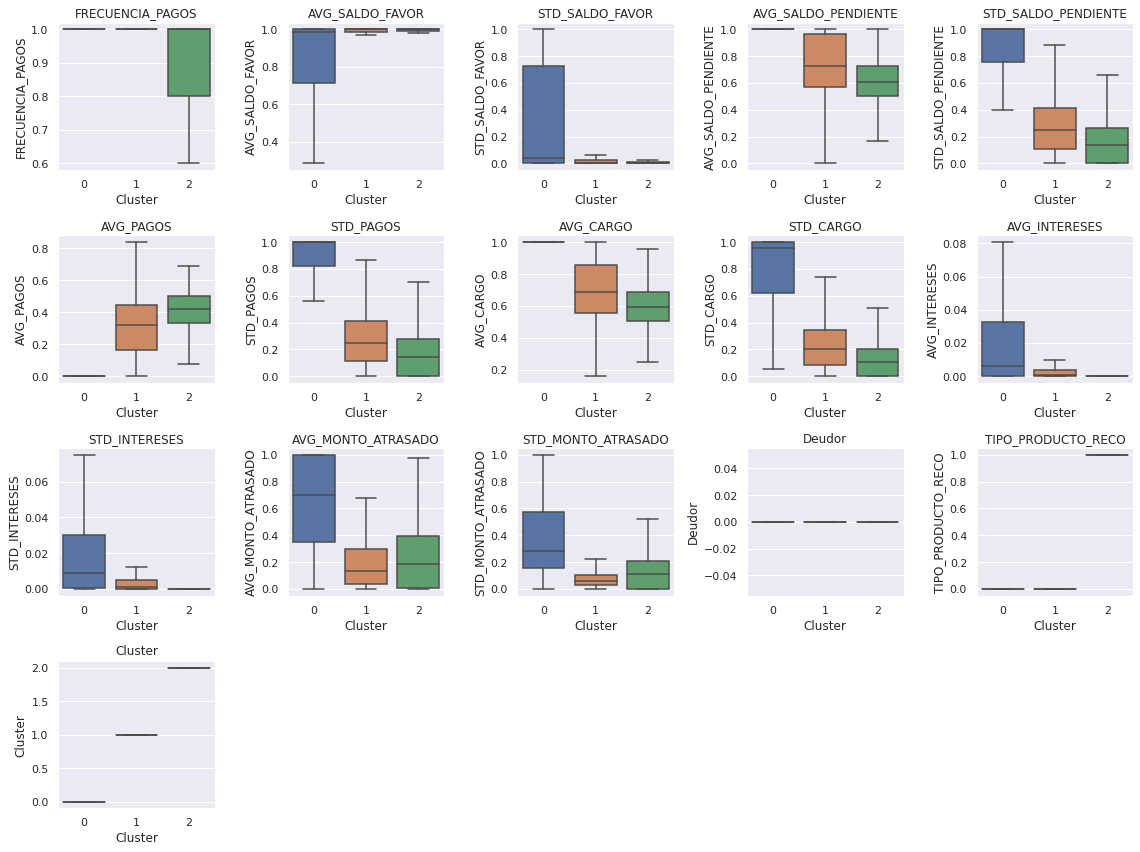

In [ ]:
# Se realizan los gráficos de boxplot para explorar si los cluster definidos presentan diferencias significativas en su distribución y si esto permite perfilar 3 tipos de clientes
plt.figure(figsize=(16,12))
rows = 4
cols = (df_cluster_3.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_cluster_3.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object':
      sns.boxplot(x=df_cluster_3['Cluster'],
                  y=serie,
                  showfliers=False)
      plt.title(colnames)
      
        
plt.tight_layout()

Text(0, 0.5, 'Promedio de montos atrasados')

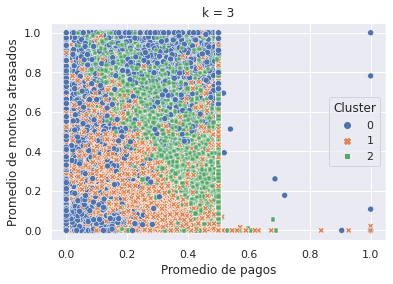

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de pagos
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_3,  
                x='AVG_PAGOS', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 3')

ax1.set_xlabel('Promedio de pagos')
ax1.set_ylabel('Promedio de montos atrasados')

Text(0, 0.5, 'Promedio de montos atrasados')

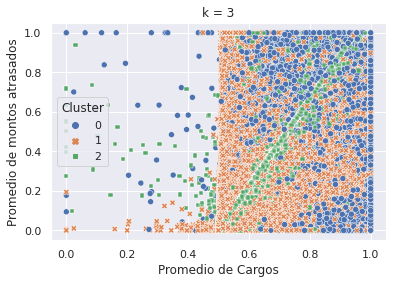

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de cargos mensuales
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_3,  
                x='AVG_CARGO', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 3')

ax1.set_xlabel('Promedio de Cargos')
ax1.set_ylabel('Promedio de montos atrasados')

## Entrenamiento con K=4

In [ ]:
%%time 
# Se entrena el modelo con k=4
kmeans_4 = KMeans(n_clusters=4, random_state=1, max_iter=300).fit(df_norm)

CPU times: user 45.3 s, sys: 4.28 s, total: 49.6 s
Wall time: 29.6 s


In [ ]:
# Se obtiene nuevo df
df_cluster_4=df_norm

In [ ]:
# Se añaden las asignaciones de cluster al nuevo df
df_cluster_4["Cluster"]=kmeans_4.labels_

In [ ]:
# Se realiza una exploración de la cantidad de asignaciones para cada cluster
df_cluster_4["Cluster"].value_counts('%')

0    0.376130
1    0.302103
3    0.230772
2    0.090995
Name: Cluster, dtype: float64

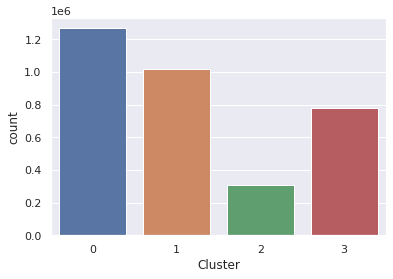

In [ ]:
# Se realiza una exploración gráfica de la distribución
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Cluster", data=df_cluster_4)

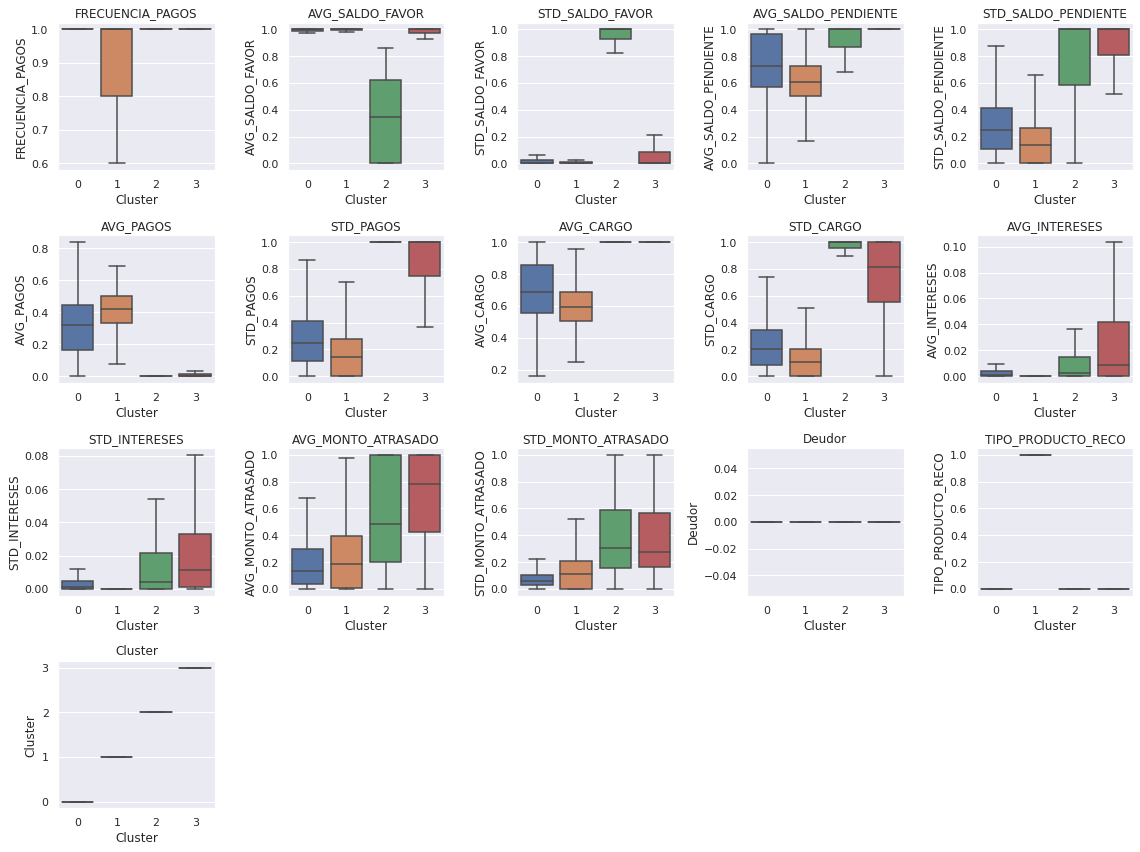

In [ ]:
# Se realizan los gráficos de boxplot para explorar si los cluster definidos presentan diferencias significativas en su distribución y si esto permite perfilar 4 tipos de clientes
plt.figure(figsize=(16,12))
rows = 4
cols = (df_cluster_4.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_cluster_4.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object':
      sns.boxplot(x=df_cluster_4['Cluster'],
                  y=serie,
                  showfliers=False)
      plt.title(colnames)
      
        
plt.tight_layout()

Text(0, 0.5, 'Promedio de montos atrasados')

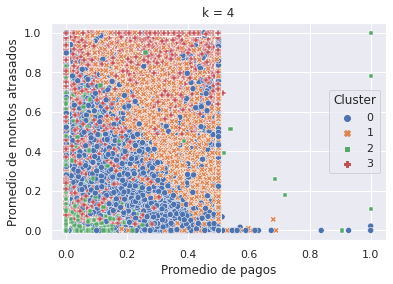

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de pagos
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_4,  
                x='AVG_PAGOS', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 4')

ax1.set_xlabel('Promedio de pagos')
ax1.set_ylabel('Promedio de montos atrasados')

Text(0, 0.5, 'Promedio de montos atrasados')

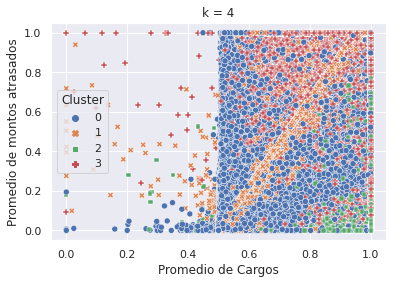

In [ ]:
# Se realiza un análisis bi variado de del atributo promedio de monto atrasado en función del promedio de cargos mensuales
# Esto tiene por objetivo visualizar si se identifican claramente la cantidad de clusters en estudio

fig, ax1 = plt.subplots(1, 1)
ax1 = sns.scatterplot(data=df_cluster_4,  
                x='AVG_CARGO', 
                y="AVG_MONTO_ATRASADO", 
                hue="Cluster",
                legend="full",
                palette="deep",
                style="Cluster")

ax1.set_title('k = 4')

ax1.set_xlabel('Promedio de Cargos')
ax1.set_ylabel('Promedio de montos atrasados')

## **Conclusiones:**
* Según las gráficas de boxplot y análisis bi variados, se determina que la mejor diferenciación de cluster se obtiene con k=3 

* Lo anterior, se debe a que en las gráficas de boxplot se logra identificar 
límites distintos para las cajas (que concentran el 50% de los datos), además de características como el tipo de producto que diferencian los cluster.

* De los análisis bivariados, se observa que a medida que aumentan el número de cluster, son los grupos más grandes que se van dividiendo en sub zonas. Pero, que al pasar de 3 a 4 cluster, el grupo mayor no obtiene una división clara.

* No se realizan todos los gráficos bivariados en conjunto como subplots, debido a la gran cantidad de datos que se deben graficar. Para esta tarea se debe contar con mayor capacidad de procesamiento. 

## **Caracterización de clientes**

En esta sección se realizará la carectirzación de cada uno de los clusters obtenidos. Para esto se estudiarán mediantes gráficas de boxplot las distribuciones de cada atributos, los porcentajes de deudores, clientes con tipo de producto y frecuencias de pago por clusters; y la estadística descriptiva por clusters.

In [ ]:
# Para realizar la caracterización, se trabajará con los datos si normalizar 
# ya que permite tener un acercamiento más real a los datos con los que cuenta la empresa

df_final=df_pro

In [ ]:
# Ahora se le incluye la variable con los cluster asignados
df_final['Cluster']=kmeans_3.labels_

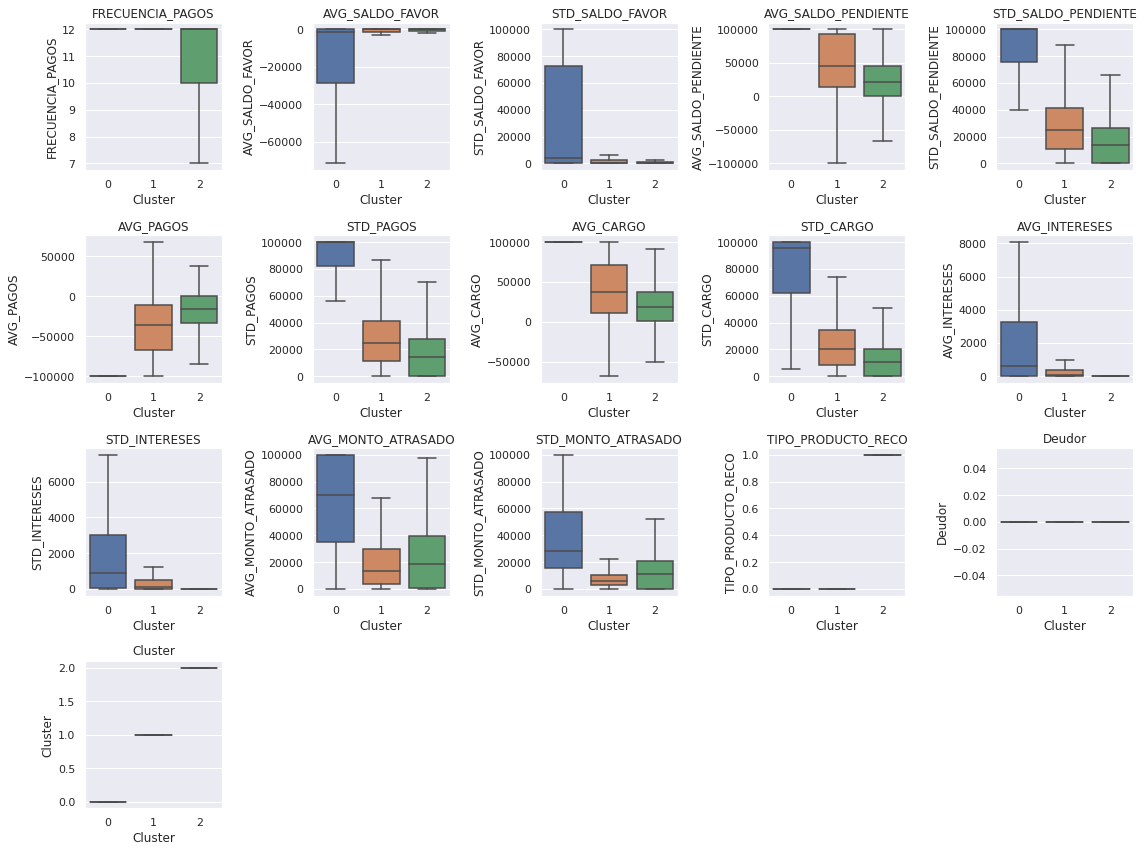

In [ ]:
# Se procede a graficar los boxplot y obtener las estadísticas descriptivas para caracterizar a los clientes
plt.figure(figsize=(16,12))
rows = 4
cols = (df_final.shape[ 1 ] // rows)+1
for index, (colnames, serie) in enumerate(df_final.iteritems()):
    plt.subplot(rows, cols, index + 1 )
    if serie.dtype != 'object':
      sns.boxplot(x=df_final['Cluster'],
                  y=serie,
                  showfliers=False)
      plt.title(colnames)
      
        
plt.tight_layout()

In [ ]:
# Se estudia la proporcion de deudores o no deudores en cada uno de los clusters
df_final.groupby(by='Cluster')['Deudor'].value_counts('%')

Cluster  Deudor
0        0         0.895659
         1         0.104341
1        0         0.950144
         1         0.049856
2        0         0.882035
         1         0.117965
Name: Deudor, dtype: float64

In [ ]:
# Se estudia la proporción de clientes con tipo de productos en cada uno de los clusters
df_final.groupby(by='Cluster')['TIPO_PRODUCTO_RECO'].value_counts('%')

Cluster  TIPO_PRODUCTO_RECO
0        0                     0.915467
         1                     0.084533
1        0                     1.000000
2        1                     0.998824
         0                     0.001176
Name: TIPO_PRODUCTO_RECO, dtype: float64

In [ ]:
## Se estudia la proporción de de la frecuencia de pagos en cada uno de los clusters
df_final.groupby(by='Cluster')['FRECUENCIA_PAGOS'].value_counts('%')

Cluster  FRECUENCIA_PAGOS
0        12                  0.845645
         11                  0.028102
         10                  0.021116
         9                   0.017428
         8                   0.015493
         7                   0.014718
         6                   0.013569
         5                   0.013050
         4                   0.011685
         2                   0.010074
         3                   0.009119
1        12                  0.815715
         11                  0.028007
         10                  0.022103
         2                   0.020044
         9                   0.019408
         8                   0.017523
         7                   0.016647
         4                   0.015635
         5                   0.015188
         6                   0.015028
         3                   0.014702
2        12                  0.713097
         11                  0.035862
         2                   0.033309
         5              

In [ ]:
# Se obtiene la estadística descriptiva del cluster 0
df_final[df_final['Cluster']==0].describe()

,FRECUENCIA_PAGOS,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO,TIPO_PRODUCTO_RECO,Deudor,Cluster
count,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1.084940e+06,1084940.0
mean,1.129276e+01,-2.084256e+04,3.191794e+04,9.307103e+04,8.634605e+04,-9.228168e+04,8.895626e+04,9.398459e+04,8.020367e+04,3.351630e+03,2.227823e+03,6.532937e+04,3.966148e+04,8.453279e-02,1.043413e-01,0.0
std,2.001736e+00,3.301577e+04,4.097312e+04,2.241704e+04,2.141239e+04,1.839869e+04,1.927681e+04,1.498568e+04,2.462591e+04,7.354460e+03,3.579135e+03,3.353161e+04,3.067878e+04,2.781853e-01,3.057029e-01,0.0
min,2.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.200000e+01,-2.862542e+04,1.775251e+00,1.000000e+05,7.592646e+04,-1.000000e+05,8.242120e+04,1.000000e+05,6.226040e+04,1.516667e+01,4.128054e+01,3.534412e+04,1.593852e+04,0.000000e+00,0.000000e+00,0.0
50%,1.200000e+01,-1.332917e+03,3.959634e+03,1.000000e+05,1.000000e+05,-1.000000e+05,1.000000e+05,1.000000e+05,9.553571e+04,6.061667e+02,8.919985e+02,7.015517e+04,2.822700e+04,0.000000e+00,0.000000e+00,0.0
75%,1.200000e+01,-6.666667e-01,7.273738e+04,1.000000e+05,1.000000e+05,-1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,3.240417e+03,3.024593e+03,1.000000e+05,5.708792e+04,0.000000e+00,0.000000e+00,0.0
max,1.200000e+01,0.000000e+00,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+00,1.000000e+00,0.0


In [ ]:
# Se obtiene la estadística descriptiva del cluster 1
df_final[df_final['Cluster']==1].describe()

,FRECUENCIA_PAGOS,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO,TIPO_PRODUCTO_RECO,Deudor,Cluster
count,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1.269215e+06,1269215.0,1.269215e+06,1269215.0
mean,1.106192e+01,-2.928402e+03,5.362793e+03,4.914808e+04,2.805041e+04,-4.173536e+04,2.743853e+04,4.298115e+04,2.315137e+04,7.463904e+02,3.958841e+02,2.099107e+04,8.226167e+03,0.0,4.985601e-02,1.0
std,2.364051e+00,9.013902e+03,1.331089e+04,3.867141e+04,2.278878e+04,3.389837e+04,2.084476e+04,3.465789e+04,1.881896e+04,2.264058e+03,6.929476e+02,2.341639e+04,1.051518e+04,0.0,2.176475e-01,0.0
min,2.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.0
25%,1.200000e+01,-1.173250e+03,0.000000e+00,1.332394e+04,1.049016e+04,-6.771592e+04,1.103611e+04,1.150248e+04,8.386215e+03,0.000000e+00,0.000000e+00,3.636367e+03,2.547254e+03,0.0,0.000000e+00,1.0
50%,1.200000e+01,-9.416667e+00,6.665151e+00,4.569380e+04,2.452510e+04,-3.569497e+04,2.491451e+04,3.689877e+04,2.031354e+04,4.644444e+01,8.547525e+01,1.351925e+04,5.801973e+03,0.0,0.000000e+00,1.0
75%,1.200000e+01,-1.000000e+00,2.486468e+03,9.286871e+04,4.149746e+04,-1.153519e+04,4.130558e+04,7.141790e+04,3.459430e+04,3.882864e+02,4.843969e+02,2.945125e+04,1.045605e+04,0.0,0.000000e+00,1.0
max,1.200000e+01,0.000000e+00,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.793543e+04,1.000000e+05,1.000000e+05,0.0,1.000000e+00,1.0


In [ ]:
# Se obtiene la estadística descriptiva del cluster 2
df_final[df_final['Cluster']==2].describe()

,FRECUENCIA_PAGOS,AVG_SALDO_FAVOR,STD_SALDO_FAVOR,AVG_SALDO_PENDIENTE,STD_SALDO_PENDIENTE,AVG_PAGOS,STD_PAGOS,AVG_CARGO,STD_CARGO,AVG_INTERESES,STD_INTERESES,AVG_MONTO_ATRASADO,STD_MONTO_ATRASADO,TIPO_PRODUCTO_RECO,Deudor,Cluster
count,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1.019059e+06,1019059.0
mean,1.043441e+01,-2.418839e+03,3.863679e+03,2.816088e+04,1.762539e+04,-2.256472e+04,1.855718e+04,2.477030e+04,1.422314e+04,9.555342e+00,1.273021e+00,2.565848e+04,1.437821e+04,9.988244e-01,1.179647e-01,2.0
std,2.940752e+00,8.213123e+03,1.083596e+04,3.048127e+04,1.821981e+04,2.470339e+04,1.913207e+04,2.561492e+04,1.544590e+04,3.430357e+02,6.210085e+01,2.709339e+04,1.586007e+04,3.426680e-02,3.225665e-01,0.0
min,2.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,-1.000000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0
25%,1.000000e+01,-6.619167e+02,0.000000e+00,3.456000e+02,0.000000e+00,-3.417779e+04,0.000000e+00,1.508400e+03,1.847232e+02,0.000000e+00,0.000000e+00,4.180000e+02,0.000000e+00,1.000000e+00,0.000000e+00,2.0
50%,1.200000e+01,-6.416667e+00,2.309401e+00,2.106501e+04,1.362440e+04,-1.608548e+04,1.433194e+04,1.864808e+04,1.062942e+04,0.000000e+00,0.000000e+00,1.876333e+04,1.092402e+04,1.000000e+00,0.000000e+00,2.0
75%,1.200000e+01,-8.181818e-01,9.039220e+02,4.506754e+04,2.632367e+04,0.000000e+00,2.805035e+04,3.765998e+04,2.056816e+04,0.000000e+00,0.000000e+00,3.945095e+04,2.095524e+04,1.000000e+00,0.000000e+00,2.0
max,1.200000e+01,0.000000e+00,1.000000e+05,1.000000e+05,1.000000e+05,3.779100e+04,1.000000e+05,1.000000e+05,1.000000e+05,7.890000e+04,1.617153e+04,1.000000e+05,1.000000e+05,1.000000e+00,1.000000e+00,2.0


In [ ]:
# Se comparan los promedios de los atributos
caracterizacion_mean=pd.DataFrame(df_final[df_final['Cluster']==0].mean().round(2))
caracterizacion_mean['1']=df_final[df_final['Cluster']==1].mean().round(2)
caracterizacion_mean['2']=df_final[df_final['Cluster']==2].mean().round(2)
caracterizacion_mean.columns=['Cluster 0', 'Cluster 1', 'Cluster 2']

#Se imprime la tabla
caracterizacion_mean

,Cluster 0,Cluster 1,Cluster 2
FRECUENCIA_PAGOS,11.29,11.06,10.43
AVG_SALDO_FAVOR,-20842.56,-2928.40,-2418.84
STD_SALDO_FAVOR,31917.94,5362.79,3863.68
AVG_SALDO_PENDIENTE,93071.03,49148.08,28160.88
STD_SALDO_PENDIENTE,86346.05,28050.41,17625.39
AVG_PAGOS,-92281.68,-41735.36,-22564.72
STD_PAGOS,88956.26,27438.53,18557.18
AVG_CARGO,93984.59,42981.15,24770.30
STD_CARGO,80203.67,23151.37,14223.14
AVG_INTERESES,3351.63,746.39,9.56


## **Conclusiones de la clusterización**:

**Cluster 0:**
* Proporciones de: 90 % no deudores, 92 % Tipo de producto revolving y 85 % de Frecuencia de pagos igual a 12 meses. 
* Respecto a sus atributos promedio tenemos que el Saldo Pendiente $34.441, Saldo a favor 2.454, pagos 29.531, Cargos 30.699 

**Cluster 1:** 
* Proporciones de: 95 % no deudores, 100 % Tipo de producto revolving y 82 % de Frecuencia de pagos igual a 12 meses. 
* Respecto a sus atributos promedio tenemos que el Saldo Pendiente 91.426, Saldo a favor 16.636, pagos 88.474.531 , Cargos 90.227

**Cluster 2:**  
* Proporciones de: 88 % no deudores, 100 % Tipo de producto Cuotas y 71 % de Frecuencia de pagos igual a 12 meses.
* Respecto a sus atributos promedio tenemos que el Saldo Pendiente 25.480, Saldo a favor 2.384, pagos 20.210, Cargos $22.280


## **Comentarios sobre clusterización:**
* Se observa que se tienen 2 segmentos principales de clientes:

    1. Segmento alto, constituido por el cluster número 1
    2. Segmento bajo, constituido por los clusters 0 y 2

* Respecto al segmento alto, se observa que los flujos de dinero son más altos, cercano a los 90.000 promedio. Por lo que corresponde a un segmento de clientes con mayor poder adquisitivo y capacidad de deuda. Los tipos de productos que podrían ser ofrecidos a este segmento son creditos con bajas tasas de interés, créditos con un mayor valor, repactación de deuda para el caso de los clientes deudores dentro del cluster.



* Respecto al segmento bajo, se observan flujos de dínero más bajos, en el rando de los 20.000 y 30.000. La principal diferencianción entre cluster 0 y 2, es que el primero tiene un porcentaje mayor de (92%) de clientes con pago revolving, en comparación con el cluster 2 que tiene un 100% de sus clientes con pago en cuotas. Los productos que podrían ser ofrecidos en este segmento son aumentos de cupo en tarjetas de crédito, ventas en un mayor número de cutoas para tener que pagar precios más bajos y repactación de deudas.

## **Oportunidades de mejora**:
* Una alternativa que podría mejorar la segmentación, desde el punto de vista de clusters más marcados, es la inclusión de más información financiera, como por ejemplo demografía, sexo, edad, etc.

* Debido a la capacitdad de procesamiento disponible y simplicidad del modelo, se opta por trabajar con el modelo de kmeans. En caso de que se cuente con una mayor capacidad de procesamiento, se podría explorar el uso de otros algoritmos como por ejemplo Gaussian mixtures, Affinity propagation, entre otros. Los cuales tienen una mayor demanda en el procesamiento matemático.

* Adicional a lo anterior, al utilizar otros tipos de modelos, también se podría explorar aumentar la cantidad de clusters, en vista de mejorar la estrategia de oferta de productos.

# **Conclusiones finales**
* Se logra implementar un modelo de clusterización, mediante algortimo de kmeans. El cual se propone como una solución a la problematica presentada por el retail para una mejora en la estrategia de oferta de productos financieros.
* Se define la clasificación de clientes en 3 grupos. Además, se entrega las características definidas para cada grupo.
* Se proponen oportunidades de mejora que permitirían aumentar el desempeño del modelo, en vista de tener una definición más marcada de cada uno de los clusters.